## Correcting for firing rate when comparing spike-field and spike-spike coherence

Spike-field and spike-spike coherence increases with firing rate, independent of the strength of coupling between neuron and local field potential (LFP) or neuron and neuron (Lepage et al. 2011). 

This confounds analyses comparing spike-field and spike-spike coherence when the firing rates are different between experimental conditions by making it appear as if there is an increase in coupling when there is only a difference in firing rate.

A common method for correcting for this is to randomly remove spikes from the higher firing rate condition until it matches the lower firing rate condition ('thinning'). But this has the problem of removing information provided by the spikes and being computationally expensive.

This repository implements an alternative method from **Aoi et al. (2015)** which:
+ has improved detectability for coupling-related changes in spike-field and spike-spike coherence
+ is computationally less complex.

See References for further details.

### Demonstration of the method and code

In [18]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

np.random.seed(1234)

First we simulate a LFP using parameters from Aoi et al. 2016

In [3]:
from statsmodels.tsa.arima_process import ArmaProcess

def simulate_LFP():
    n_time, n_trials = 1000, 100
    ar = np.array([1.911, -0.95])
    ma = np.array([0.])
    ar = np.r_[1, -ar] # add zero-lag and negate
    ma = np.r_[1, ma] # add zero-lag
    arma_process = ArmaProcess(ar, ma)

    return np.stack([arma_process.generate_sample(n_time)
                     for _ in np.arange(n_trials)], axis=1)

sampling_frequency = 1000
lfp = simulate_LFP()
lfp = lfp / np.max(np.abs(lfp), axis=0)

This LFP has a spectral peak at 31 Hz.

INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=1.0, time_window_step=1.0, detrend_type='constant', start_time=0, n_tapers=9)


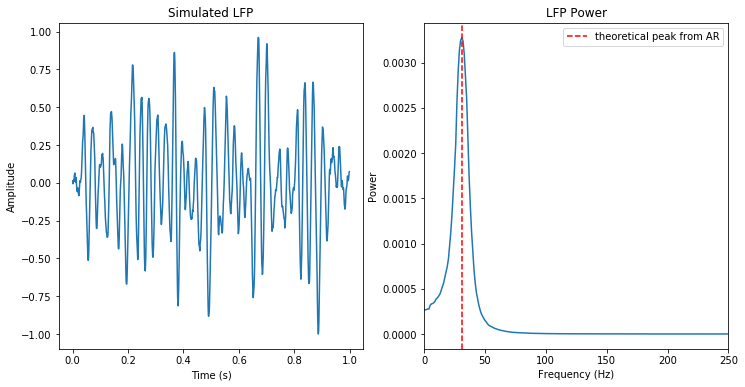

In [4]:
from src.spectral import Multitaper, Connectivity

m = Multitaper(lfp[..., np.newaxis], sampling_frequency, time_halfbandwidth_product=5)
c = Connectivity.from_multitaper(m)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

n_time = lfp.shape[0]
time = np.arange(n_time) / sampling_frequency

axes[0].plot(time, lfp[:, 0])
axes[0].set_ylabel('Amplitude')
axes[0].set_xlabel('Time (s)')
axes[0].set_title('Simulated LFP')

axes[1].plot(c.frequencies, c.power().squeeze());
axes[1].set_xlim((0, 250))
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power')
axes[1].axvline(31, color='red', linestyle='--', label='theoretical peak from AR')
axes[1].set_title('LFP Power');
plt.legend();

We simulate the spikes based on the LFP amplitude, taking the exponential to keep the rate strictly positive.

In [5]:
def simulate_spikes(mean_spike_rate, lfp, sampling_frequency):
    rate = mean_spike_rate * np.exp(lfp)
    return np.random.poisson(rate / sampling_frequency)

spikes = simulate_spikes(20, lfp, sampling_frequency)

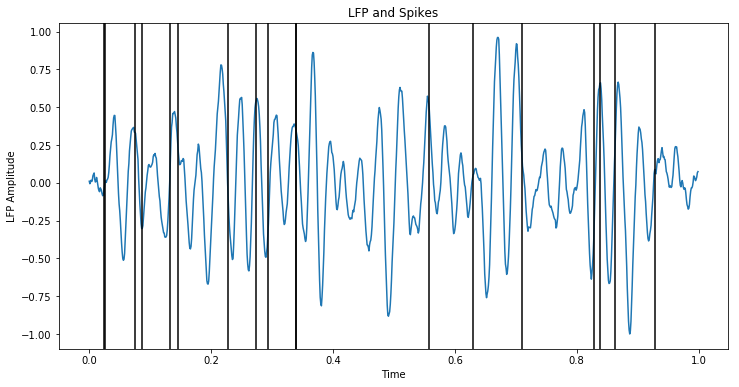

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
trial = 0
ax.plot(time, lfp[:, trial])
for spike_time in time[np.nonzero(spikes[:, trial])[0]]:
    ax.axvline(spike_time, color='black')

plt.xlabel('Time')
plt.ylabel('LFP Amplitude')
plt.title('LFP and Spikes');

#### Unadjusted Spike-Field Coherence
Now we show the dependence on spike-field coherence on the firing rate.

We simulate a neuron with average firing rates ranging from 20 Hz to 100 Hz. The spike-field coherence increases from 0.06 to 0.27 strictly due to changes in the average firing rate.

INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=1.0, time_window_step=1.0, detrend_type='constant', start_time=0, n_tapers=9)
INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=1.0, time_window_step=1.0, detrend_type='constant', start_time=0, n_tapers=9)
INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=1.0, time_window_step=1.0, detrend_type='constant', start_time=0, n_tapers=9)
INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=1.0, time_window_step=1.0, detrend_type='constant', start_time=0, n_tapers=9)
INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=1.0, time_window_step=1.0, detrend_type='constant', start_time=0, n_tapers=9)


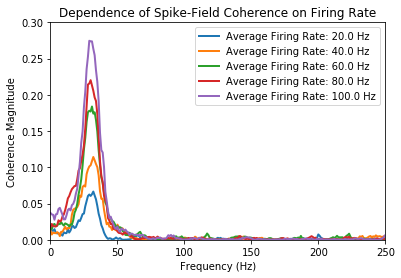

In [7]:
plt.figure(figsize=(6, 4))

for mean_spike_rate in np.linspace(20, 100, 5):
    spikes = simulate_spikes(mean_spike_rate, lfp, sampling_frequency)
    m = Multitaper(np.stack((lfp, spikes), axis=-1), sampling_frequency, time_halfbandwidth_product=5)
    c = Connectivity.from_multitaper(m)
    plt.plot(c.frequencies, c.coherence_magnitude()[0, :, 0, 1],
             label=('Average Firing Rate: {0} Hz'.format(mean_spike_rate)),
             linewidth=2)
    
plt.legend()
plt.xlim((0, 250))
plt.ylim((0, 0.30))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence Magnitude')
plt.title('Dependence of Spike-Field Coherence on Firing Rate');

#### Rate-Adjusted Spike-Field Coherence
Now we adjust the complex coherencey so that the spike-field coherence is the same regardless of the differences in the firing rate. Note that the adjustment must be applied to the complex coherency before taking the squared magnitude of the coherence.

In this case, we are adjusting all the firing rates to 60 Hz. In practice, we would adjust the average firing rate from condition 1 to condition 2 (or vice versa).

In [8]:
def coherence_rate_adjustment(firing_rate_condition1,
                              firing_rate_condition2, spike_power_spectrum,
                              homogeneous_poisson_noise=0, dt=1):
    '''Correction for the spike-field or spike-spike coherence when the
    conditions have different firing rates.

    When comparing the coherence of two conditions, a change in firing rate
    results in a change in coherence without an increase in coupling.
    This adjustment modifies the coherence of one of the conditions, so
    that a difference in coherence between conditions indicates a change
    in coupling, not firing rate. See [1] for details.

    If using to compare spike-spike coherence, not that the coherence
    adjustment must be applied twice, once for each spike train.

    Adjusts `firing_rate_condition1` to `firing_rate_condition2`.

    Parameters
    ----------
    firing_rate_condition1, firing_rate_condition2 : float
        Average firing rates for each condition.
    spike_power_spectrum : ndarray, shape (n_frequencies,)
        Power spectrum of the spike train in condition 1.
    homogeneous_poisson_noise : float, optional
        Beta in [1].
    dt : float, optional
        Size of time step.

    Returns
    -------
    rate_adjustment_factor : ndarray, shape (n_frequencies)

    References
    ----------
    .. [1] Aoi, M.C., Lepage, K.Q., Kramer, M.A., and Eden, U.T. (2015).
           Rate-adjusted spike-LFP coherence comparisons from spike-train
           statistics. Journal of Neuroscience Methods 240, 141-153.

    '''
    # alpha in [1]
    firing_rate_ratio = firing_rate_condition2 / firing_rate_condition1
    adjusted_firing_rate = (
        (1 / firing_rate_ratio - 1) * firing_rate_condition1 +
        homogeneous_poisson_noise / firing_rate_ratio ** 2) * dt ** 2
    return 1 / np.sqrt(1 + (adjusted_firing_rate / spike_power_spectrum))

INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=1.0, time_window_step=1.0, detrend_type='constant', start_time=0, n_tapers=9)
INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=1.0, time_window_step=1.0, detrend_type='constant', start_time=0, n_tapers=9)
INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=1.0, time_window_step=1.0, detrend_type='constant', start_time=0, n_tapers=9)
INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=1.0, time_window_step=1.0, detrend_type='constant', start_time=0, n_tapers=9)
INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=1.0, time_window_step=1.0, detrend_type='constant', start_time=0, n_tapers=9)


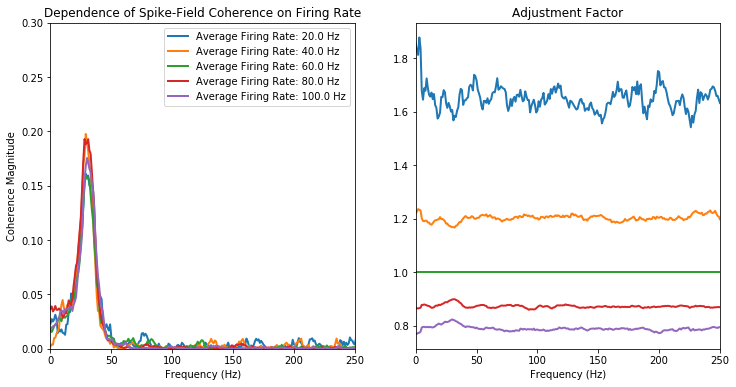

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

TARGET_FIRING_RATE = 60

for mean_spike_rate in np.linspace(20, 100, 5):
    spikes = simulate_spikes(mean_spike_rate, lfp, sampling_frequency)
    m = Multitaper(np.stack((lfp, spikes), axis=-1), sampling_frequency, time_halfbandwidth_product=5)
    c = Connectivity.from_multitaper(m)
    
    spike_power_spectrum = c.power()[..., 1].squeeze()
    
    adjustment = coherence_rate_adjustment(
        mean_spike_rate, TARGET_FIRING_RATE,
        spike_power_spectrum, dt=1/sampling_frequency)
    
    
    axes[0].plot(c.frequencies, np.abs(adjustment * c.coherency()[0, :, 0, 1]) ** 2,
             label=('Average Firing Rate: {0} Hz'.format(mean_spike_rate)),
             linewidth=2)
    axes[1].plot(c.frequencies, adjustment, label=('Average Firing Rate: {0} Hz'.format(mean_spike_rate)),
             linewidth=2)
    
axes[0].set_xlim((0, 250))
axes[0].set_ylim((0, 0.30))
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Coherence Magnitude')
axes[0].set_title('Dependence of Spike-Field Coherence on Firing Rate');
axes[0].legend()

axes[1].set_xlim((0, 250))
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_title('Adjustment Factor');

## Spike-Spike Coherence Adjustment

For spike-spike coherence, the adjustment must be applied twice -- once for each neuron. We show how to do this here and show how it impacts the estimate of the differences of coherences.

#### No difference, not adjusted

We simulate two coherent signals in different conditions, with the only difference being an increase in spiking rate during the second condition. So the true difference between conditions should be 0.

In [10]:
frequency_of_interest = 30
sampling_frequency = 1000
time_extent = (0, 4.000)
n_trials, n_signals = 1000, 2

n_time_samples = int(((time_extent[1] - time_extent[0]) * sampling_frequency) + 1)
time = np.linspace(time_extent[0], time_extent[1], num=n_time_samples, endpoint=True)[:, np.newaxis]

signal = np.zeros((n_time_samples, n_trials, n_signals))
signal[:, :, 0] = np.sin(2 * np.pi * time * frequency_of_interest)

phase_offset = np.pi / 2
signal[:, :, 1] = np.sin((2 * np.pi * time * frequency_of_interest) + phase_offset)
noise = np.random.normal(0, 0.5, signal.shape)
signal = signal + noise
signal = signal / np.max(np.abs(signal), axis=1, keepdims=True)

RATE1 = 50
RATE2 = 100
spikes_condition1 = simulate_spikes(RATE1, signal, sampling_frequency)
spikes_condition2 = simulate_spikes(RATE2, signal, sampling_frequency)

In [11]:
m1 = Multitaper(spikes_condition1, sampling_frequency, time_halfbandwidth_product=5)
c1 = Connectivity.from_multitaper(m1)

m2 = Multitaper(spikes_condition2, sampling_frequency, time_halfbandwidth_product=5)
c2 = Connectivity.from_multitaper(m2)

INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=4.001, time_window_step=4.001, detrend_type='constant', start_time=0, n_tapers=9)
INFO:src.spectral.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5, time_window_duration=4.001, time_window_step=4.001, detrend_type='constant', start_time=0, n_tapers=9)


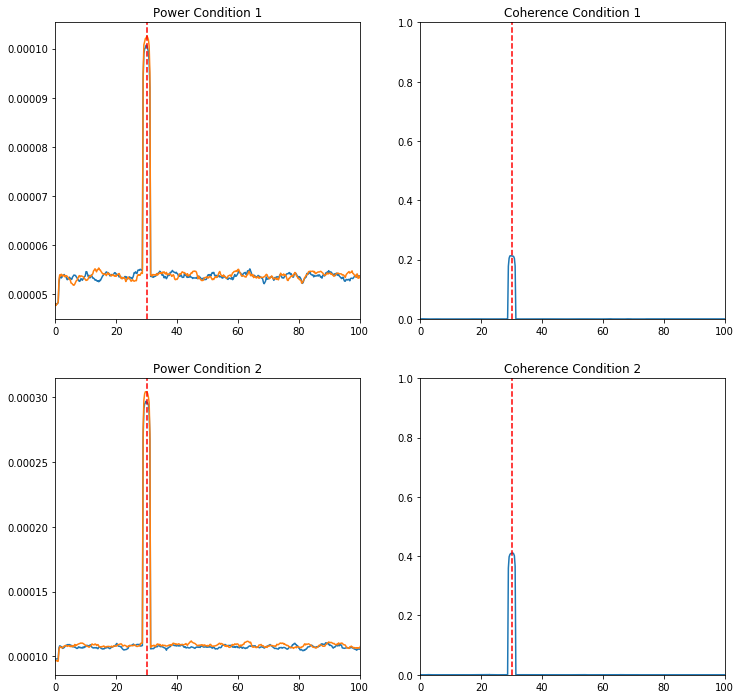

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].plot(c1.frequencies, c1.power()[..., 0].squeeze())
axes[0, 0].plot(c1.frequencies, c1.power()[..., 1].squeeze())
axes[0, 0].set_xlim((0, 100))
axes[0, 0].set_title('Power Condition 1')
axes[0, 0].axvline(30, linestyle='--', color='red')

axes[0, 1].plot(c1.frequencies, c1.coherence_magnitude()[0, :, 0, 1])
axes[0, 1].set_xlim((0, 100))
axes[0, 1].set_ylim((0, 1))
axes[0, 1].set_title('Coherence Condition 1')
axes[0, 1].axvline(30, linestyle='--', color='red')

axes[1, 0].plot(c2.frequencies, c2.power()[..., 0].squeeze())
axes[1, 0].plot(c2.frequencies, c2.power()[..., 1].squeeze())
axes[1, 0].set_title('Power Condition 2')
axes[1, 0].set_xlim((0, 100))
axes[1, 0].axvline(30, linestyle='--', color='red')

axes[1, 1].plot(c2.frequencies, c2.coherence_magnitude()[0, :, 0, 1])
axes[1, 1].set_xlim((0, 100))
axes[1, 1].set_ylim((0, 1))
axes[1, 1].set_title('Coherence Condition 2')
axes[1, 1].axvline(30, linestyle='--', color='red');

Because of the difference in firing rate, we get an increase in coherence magnitude of ~0.20.

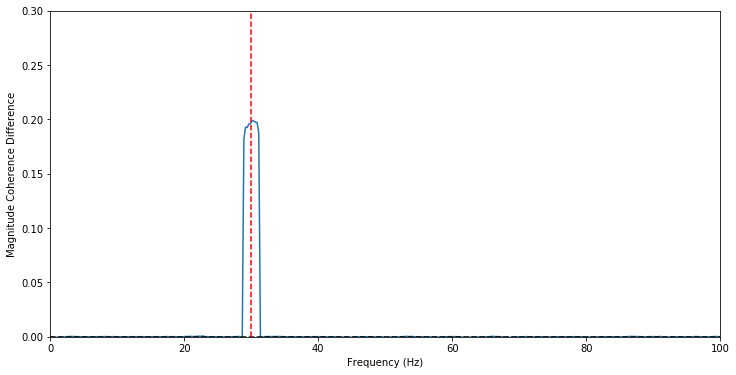

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(c1.frequencies, c2.coherence_magnitude()[0, :, 0, 1] - c1.coherence_magnitude()[0, :, 0, 1])
plt.xlim((0, 100));
plt.ylim((0, 0.30))
ax.set_ylabel('Magnitude Coherence Difference')
ax.set_xlabel('Frequency (Hz)')
ax.axhline(0, linestyle='--', color='black')
ax.axvline(30, linestyle='--', color='red');

### Adjusted Difference

Now we adjust the firing rate of condition 1 to that of condition 2. Note that each signal must be adjusted, although in our case here, we have the same firing rate conditions for both signals, so the adjustment is the same.

In [14]:
spike_power_spectrum1 = c1.power()[..., 0].squeeze()
spike_power_spectrum2 = c1.power()[..., 1].squeeze()

adjustment1 = coherence_rate_adjustment(
        RATE1, RATE2,
        spike_power_spectrum1, dt=1/sampling_frequency)
adjustment2 = coherence_rate_adjustment(
        RATE1, RATE2,
        spike_power_spectrum2, dt=1/sampling_frequency)

adjusted_coherence_magnitude1 = np.abs(adjustment2 * adjustment1 * c1.coherency()[0, :, 0, 1]) ** 2

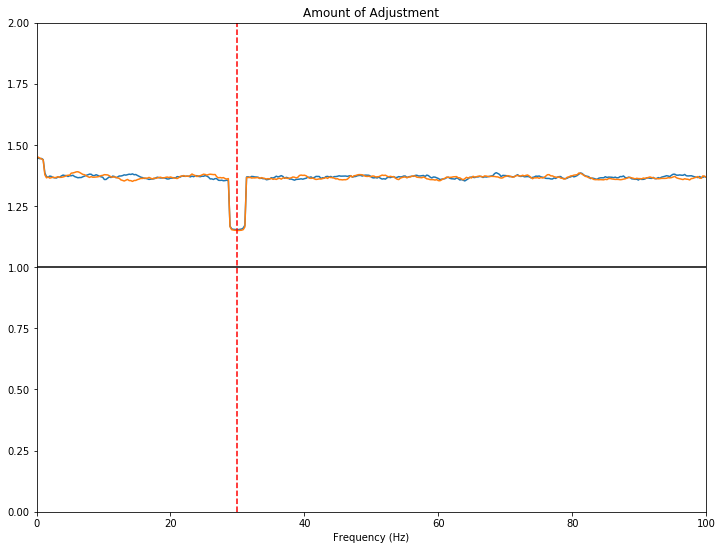

In [15]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(c1.frequencies, adjustment1, c2.frequencies, adjustment2)
ax.set_xlim((0, 100))
ax.set_ylim((0, 2))
ax.set_xlabel('Frequency (Hz)')
ax.axhline(1, color='black')
ax.set_title('Amount of Adjustment')
ax.axvline(30, linestyle='--', color='red');

After adjustment the difference in coherence magnitude is close to zero, although there is still some bias.

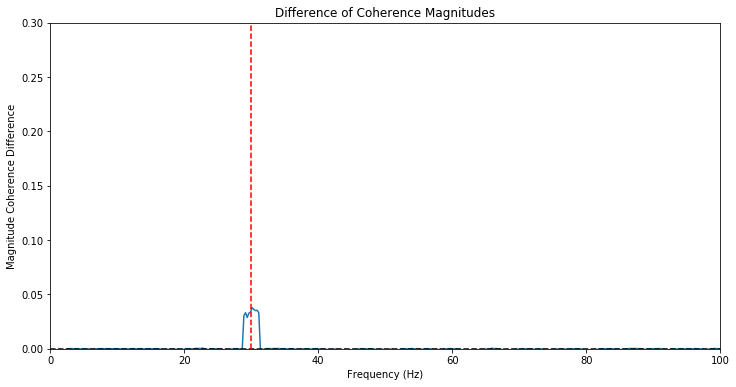

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(c1.frequencies, c2.coherence_magnitude()[0, :, 0, 1] - adjusted_coherence_magnitude1)
plt.xlim((0, 100));
plt.ylim((0, 0.30))
ax.set_ylabel('Magnitude Coherence Difference')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Difference of Coherence Magnitudes')
ax.axhline(0, linestyle='--', color='black')
ax.axvline(30, linestyle='--', color='red');

## References
1. Aoi, M.C., Lepage, K.Q., Kramer, M.A., and Eden, U.T. (2015). Rate-adjusted spike-LFP coherence comparisons from spike-train statistics. Journal of Neuroscience Methods 240, 141-153.
2. Lepage, K.Q., Kramer, M.A., and Eden, U.T. (2011). The dependence of spike field coherence on expected intensity. Neural Computation 23, 2209–2241.
